In [1]:
%matplotlib notebook
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from scipy import optimize
import xarray as xr
import os
from scipy.signal import savgol_filter
from io import StringIO
from os import listdir
from os.path import isfile, join

# Superconducting Data Fitting

## BTK model 

<IPython.core.display.Javascript object>


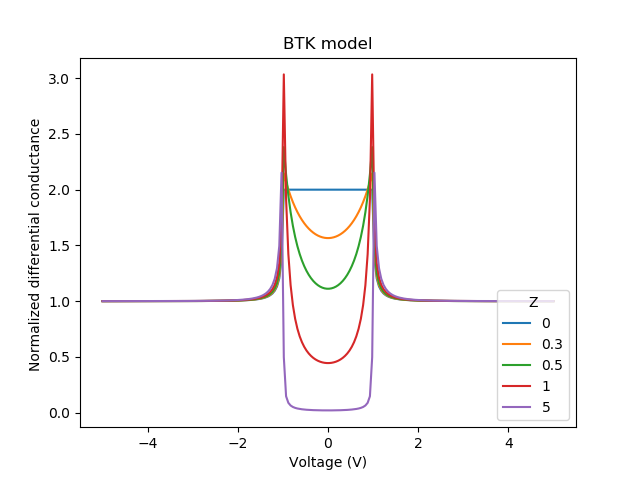

D:\anaconda\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()
D:\anaconda\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


Text(0.5,1,'BTK model')

In [2]:

Tc0 = 7

Tseq = np.arange(8.0)
chep = 0
Zseq = [0, 0.3, 0.5, 1, 5]

def BTK(Del0, Z, V, T):
    E = np.abs(V) 
    Del = Del0 
    miu0 = 1/2 * (1 + np.sqrt(E**2 - Del**2)/E )
    v0 = 1/2 * (1 - np.sqrt(E**2 - Del**2)/E )
    gamma = miu0**2 + (miu0**2 - v0**2)*Z**2
    
    if E > Del:
        A = miu0**2 * v0**2 / gamma ** 2
        B = (miu0**2 - v0**2)**2 * (Z**4 + Z**2)/ gamma**2
    else:
        A = Del**2/ (E**2 + (Del**2 - E**2) * (1 + 2* Z**2)**2)
        B = 1 - A
    return (1 + Z**2)*(1 + A - B)


fig, ax = plt.subplots()

for i in Zseq:
    Efine=np.linspace(-5,5,200)
    ax.plot(Efine, list(map(lambda x: BTK(1, i, x, 7), Efine)) , label = i )

plt.legend(title='Z', loc='lower right')
plt.ylabel('Normalized differential conductance ')
plt.xlabel('Voltage (V)')
plt.title('BTK model')


In [3]:
Data=pd.DataFrame()
filename='NbSe2-SV09-dIdV(100uV)-(S2-S6)-TSeq-2D-0.dat'
df=pd.read_csv(str(filename),skiprows=6)
df.head()

,B (T),T(mK),VOLT,V (V),I (A),X (V),Y (V),R (V),Phase (Deg)
0,-0.00022,3.798,-1.000,-1.000086,-0.000100,0.001319,-0.002472,0.002801,-61.908
1,-0.00022,3.798,-0.995,-0.995067,-0.000100,0.001323,-0.002470,0.002801,-61.818
2,-0.00022,3.798,-0.990,-0.990077,-0.000099,0.001328,-0.002467,0.002801,-61.716
3,-0.00022,3.798,-0.985,-0.985053,-0.000099,0.001331,-0.002465,0.002801,-61.638
4,-0.00022,3.798,-0.980,-0.980066,-0.000098,0.001333,-0.002463,0.002801,-61.566


In [4]:
## make recursion of all files in the dic
mypath = '.'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles = onlyfiles[:-1]

Vac = 0.1     # AC bias voltage
ACdiv=1000    # AC voltage divider
DCdiv=100     # DC voltage divider
Gain=10**(-9)    # A/V Current amplifier
#dIdV = (dIdV*Gain)/(Vac/ACdiv)/1e-6 # Calculate conductance in unit of uS

def modifydata(dd):
    dd = dd.dropna()
    cc = pd.DataFrame()
    cc = pd.concat( [ (dd.iloc[:,3]/DCdiv)/10**(-3)/2, 
                      dd.iloc[:,7]*Gain/(Vac/ACdiv)/10**(-6)   ],   # Calculate conductance in unit of uS
                    axis='columns', keys=[ 'V', 'dIdV' ])
    ##possible furture action to deal with data    
    return cc

frame = []
Tarray = []


for i in onlyfiles:
    dataname=i
    df=pd.read_csv(dataname,skiprows=6)
    cc = modifydata(df)
    frame.append(cc)
    Tarray.append( np.around( np.mean( df.iloc[:,1] ), decimals=5 ) )

exdata = pd.concat(frame, keys=Tarray, names=[ 'T'])

V_all = exdata['V']
dIdV_all = exdata['dIdV']


exdata


V      dIdV
T                              
3.79353 0   -5.000430  0.028014
        1   -4.975335  0.028012
        2   -4.950385  0.028014
        3   -4.925266  0.028014
        4   -4.900329  0.028007
        5   -4.875229  0.028000
        6   -4.850302  0.027988
        7   -4.825347  0.027960
        8   -4.800275  0.027929
        9   -4.775324  0.027888
        10  -4.750212  0.027850
        11  -4.725284  0.027819
        12  -4.700197  0.027797
        13  -4.675294  0.027786
        14  -4.650185  0.027778
        15  -4.625278  0.027769
        16  -4.600174  0.027762
        17  -4.575264  0.027750
        18  -4.550337  0.027740
        19  -4.525231  0.027731
        20  -4.500334  0.027721
        21  -4.475249  0.027721
        22  -4.450326  0.027740
        23  -4.425230  0.027766
        24  -4.400305  0.027800
        25  -4.375258  0.027843
        26  -4.350316  0.027881
        27  -4.325404  0.027914
        28  -4.300314  0.027943
        29  -4.275403  0.027969
...               ...       ...
5.60429 371  4.275680  0.027623
        372  4.300601  0.027635
        373  4.325528  0.027631
        374  4.350619  0.027626
        375  4.375521  0.027626
        376  4.400600  0.027621
        377  4.425480  0.027600
        378  4.450622  0.027573
        379  4.475517  0.027549
        380  4.500628  0.027533
        381  4.525536  0.027530
        382  4.550460  0.027540
        383  4.575546  0.027540
        384  4.600466  0.027533
        385  4.625570  0.027514
        386  4.650494  0.027499
        387  4.675559  0.027499
        388  4.700497  0.027511
        389  4.725414  0.027530
        390  4.750522  0.027557
        391  4.775453  0.027588
        392  4.800543  0.027611
        393  4.825509  0.027638
        394  4.850610  0.027678
        395  4.875555  0.027716
        396  4.900659  0.027750
        397  4.925599  0.027764
        398  4.950533  0.027771
        399  4.975633  0.027771
        400  5.000595  0.027755

[5614 rows x 2 columns]

<IPython.core.display.Javascript object>


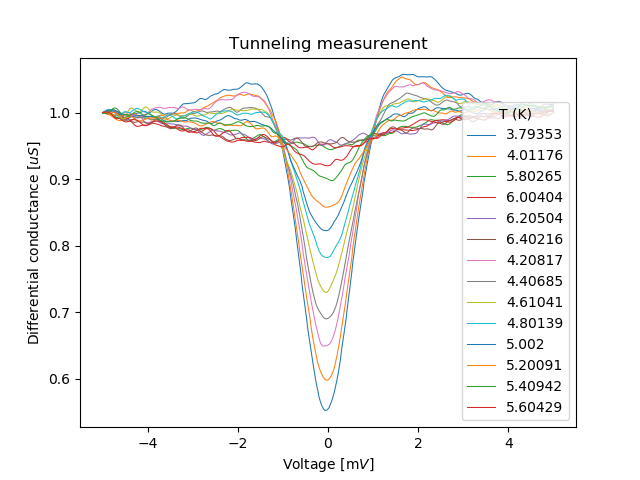

Text(0.5,1,'Tunneling measurenent')

In [5]:
fig, ax = plt.subplots()

for i in range(0,len(Tarray),1):
    Vi=V_all[Tarray[i]].tolist()
    dIdVi=dIdV_all[Tarray[i]].tolist()
    dIdVi_normalized = list(map(lambda x: x/dIdVi[0],dIdVi))
    ax.plot( Vi , dIdVi_normalized , label=Tarray[i], linestyle='solid',linewidth=0.75)

#default plotting method could not give a precise graph
    
plt.legend(title='T (K)', loc='lower right')
plt.ylabel('Differential conductance [$u$$S$]')
plt.xlabel('Voltage [m$V$]')
plt.title('Tunneling measurenent')

<IPython.core.display.Javascript object>


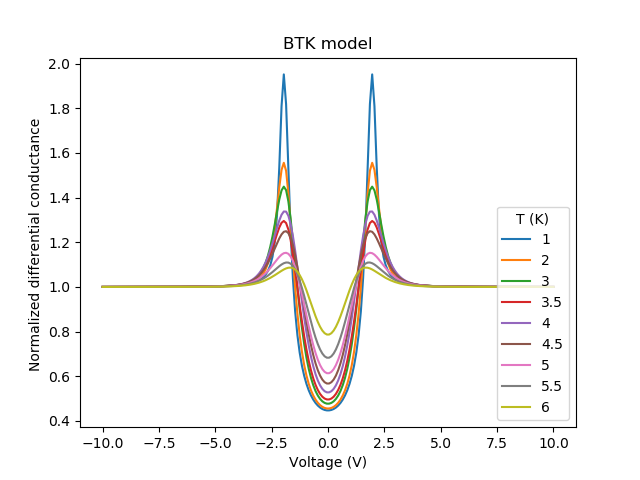

D:\anaconda\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
D:\anaconda\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


Text(0.5,1,'BTK model')

In [6]:
#define some global parameters here:
Vmax = 10.0
Tc0 = 7
Tseq = [1, 2, 3, 3.5, 4, 4.5, 5, 5.5, 6]
N = 200

e=1.6E-19
k=1.38E-23/e*1000

def df(E, V, T):
    kbt = k * T
    return  np.exp((E-V)/kbt) / (kbt * (np.exp((E-V)/kbt) + 1)**2)


def BTK(E, Del0, Z, T):
    E = np.abs(E) 
    
    Del=Del0*np.tanh(1.74*np.sqrt(Tc0/T-1))
    #Del = Del0

    miu0 = 1/2 * (1 + np.sqrt(E**2 - Del**2)/E )
    v0 = 1/2 * (1 - np.sqrt(E**2 - Del**2)/E )
    gamma = miu0**2 + (miu0**2 - v0**2)*Z**2
    
    if E > Del:
        A = miu0**2 * v0**2 / gamma ** 2
        B = (miu0**2 - v0**2)**2 * (Z**4 + Z**2)/ gamma**2
    else:
        A = Del**2/ (E**2 + (Del**2 - E**2) * (1 + 2* Z**2)**2)
        B = 1 - A
    return (1 + A - B)



def BTK_df(V, Del, Z, T): 

    Efine = np.linspace(V-Vmax, V+Vmax, N)
    dE = Efine[1]-Efine[0]
    
    dIdV_inte = 0
    
    for i in range(0, len(Efine)-1, 1):
        dIdV_step = BTK(Efine[i], Del, Z, T) * df( Efine[i], V, T )
        dIdV_inte = dIdV_step * dE + dIdV_inte
    return dIdV_inte * (1 + Z**2)


fig, ax = plt.subplots()

Vfine=np.linspace(-Vmax,Vmax,N)
Efine=np.linspace(-Vmax,Vmax,N)

Deli = 2 
Zi = 1 


for i in Tseq:
    Vfine=np.linspace(-Vmax,Vmax, N )
    ax.plot(Vfine, list(map(lambda x: BTK_df( x, Deli, Zi, i), Vfine)) , label = i )
    



plt.legend(title='T (K)', loc='lower right')
plt.ylabel('Normalized differential conductance ')
plt.xlabel('Voltage (V)')
plt.title('BTK model')

In [9]:
#choose the Temperature curve to fit

print(Tarray)

i = 0

Ti = Tarray[i]

print('Selected temperature: ')
print(Ti)
print('\n')


V=V_all[Tarray[i]].tolist()
dIdVi=dIdV_all[Tarray[i]].tolist()
dIdVi_normalized = list(map(lambda x: x/dIdVi[0],dIdVi))

dIdV = dIdVi_normalized

#define some global parameters here:
Vmax = 5
N = 200

def df_T(E, V):
    kbt = k * Ti
    return  np.exp((E-V)/kbt) / (kbt * (np.exp((E-V)/kbt) + 1)**2)


def BTK_T(E, Del0, Z):
    E = np.abs(E) 
    
    #Del=Del0*np.tanh(1.74*np.sqrt(Tc0/T-1))
    Del = Del0

    miu0 = 1/2 * (1 + np.sqrt(E**2 - Del**2)/E )
    v0 = 1/2 * (1 - np.sqrt(E**2 - Del**2)/E )
    gamma = miu0**2 + (miu0**2 - v0**2)*Z**2
    
    if E > Del:
        A = miu0**2 * v0**2 / gamma ** 2
        B = (miu0**2 - v0**2)**2 * (Z**4 + Z**2)/ gamma**2
    else:
        A = Del**2/ (E**2 + (Del**2 - E**2) * (1 + 2* Z**2)**2)
        B = 1 - A
    return (1 + A - B)



def BTK_df_T(V, Del, Z): 

    Efine = np.linspace(-2*Vmax, 2*Vmax, 2*N)
    dE = Efine[1]-Efine[0]
    
    dIdV_inte = 0
    
    for i in range(0, len(Efine)-1, 1):
        dIdV_step = BTK_T(Efine[i], Del, Z) * df_T( Efine[i], V )
        dIdV_inte = dIdV_step * dE + dIdV_inte
    return dIdV_inte * (1 + Z**2)



Deli = 0.9
Zi = 1
params = Deli, Zi




for j in range (1):
    
    params, params_covariance = optimize.curve_fit( BTK_df_T , V , dIdV, params)

    
print( 'Fitted parameters: ')
print(params , params_covariance)



ss_res_sum = 0
ss_tot_sum = 0
for i in range(0, len(V), 1):
    ss_res = np.sum((dIdV[i] - BTK_df_T(V[i], *params) ) ** 2)
    ss_res_sum += ss_res
    ss_tot = np.sum((dIdV[i] - np.mean(dIdV)) ** 2)
    ss_tot_sum += ss_tot

R2 = 1 - (ss_res_sum / ss_tot_sum)

print(R2)




[3.79353, 4.01176, 5.80265, 6.00404, 6.20504, 6.40216, 4.20817, 4.40685, 4.61041, 4.80139, 5.002, 5.20091, 5.40942, 5.60429]
Selected temperature: 
3.79353




D:\anaconda\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt
D:\anaconda\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in sqrt


Fitted parameters: 
[0.96177169 1.21197017] [[ 1.02596679e-04 -9.50556924e-05]
 [-9.50556924e-05  1.06155139e-04]]
0.9789559105086554


<IPython.core.display.Javascript object>


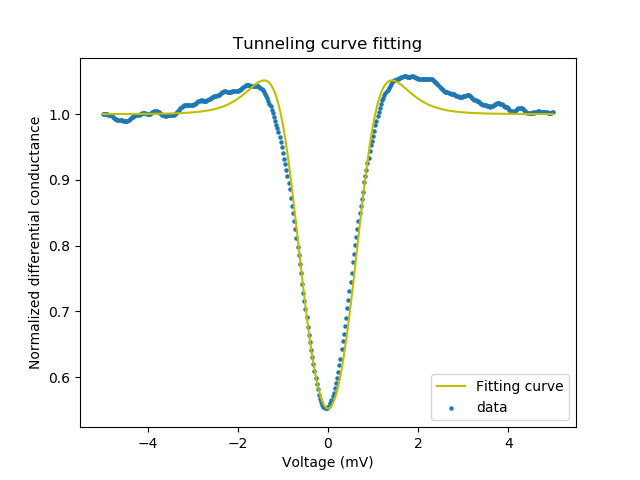

D:\anaconda\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt
D:\anaconda\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in sqrt


Text(0.5,1,'Tunneling curve fitting')

In [21]:
fig, ax = plt.subplots()

ax.scatter(V[:], dIdV[:], s=5, label = 'data')
Vfine = np.linspace(-5,5,300)
ax.plot(Vfine, list(map(lambda x: BTK_df_T( x, params[0], params[1]), Vfine)), 'y', label = 'Fitting curve' )
#ax.plot(Vfine, list(map(lambda x: BTK_df( x, params[0], params[1], T), Vfine)) )

#plt.xlim(-10,10)
plt.xlabel('Voltage (mV)')
plt.ylabel('Normalized differential conductance')
plt.legend( loc='lower right')

plt.title('Tunneling curve fitting')



In this part, effect of Gamma is considered

In [22]:
#choose the Temperature curve to fit

print(Tarray)

i = 0

Ti = Tarray[i]


print('Selected temperature: ')
print(Ti)
print('\n')


V=V_all[Tarray[i]].tolist()
dIdVi=dIdV_all[Tarray[i]].tolist()
dIdVi_normalized = list(map(lambda x: x/dIdVi[0],dIdVi))

dIdV = dIdVi_normalized

#define some global parameters here:
Vmax = 5
N = 200

def df_T(E, V):
    kbt = k * Ti
    return  np.exp((E-V)/kbt) / (kbt * (np.exp((E-V)/kbt) + 1)**2)


def BTK_T_G(E, Del0, Z, G):
    E = np.abs(E) 
    
    #Del=Del0*np.tanh(1.74*np.sqrt(Tc0/T-1))
    Del = Del0

    miu0 = 1/2 * (1 + np.sqrt(E**2 + G**2 - Del**2)/ np.sqrt(E**2 + G**2) )
    v0 = 1/2 * (1 - np.sqrt(E**2 + G**2 - Del**2)/ np.sqrt(E**2 + G**2) )
    gamma = miu0**2 + (miu0**2 - v0**2)*Z**2
    
    if E > Del:
        A = miu0**2 * v0**2 / gamma ** 2
        B = (miu0**2 - v0**2)**2 * (Z**4 + Z**2)/ gamma**2
    else:
        A = Del**2/ (E**2 + (Del**2 - E**2) * (1 + 2* Z**2)**2)
        B = 1 - A
    return (1 + A - B)



def BTK_df_T_G(V, Del, Z, G): 

    Efine = np.linspace(-2*Vmax, 2*Vmax, 2*N)
    dE = Efine[1]-Efine[0]
    
    dIdV_inte = 0
    
    for i in range(0, len(Efine)-1, 1):
        dIdV_step = BTK_T_G(Efine[i], Del, Z, G) * df_T( Efine[i], V )
        dIdV_inte = dIdV_step * dE + dIdV_inte
    return dIdV_inte * (1 + Z**2)



Deli = 0.8
Zi = 1.15
Gi = 0.2
params_2 = Deli, Zi, Gi




for j in range (5):
    
    params_2, params_covariance_2 = optimize.curve_fit( BTK_df_T_G , V , dIdV, params_2, maxfev=5000)

    
print( 'Fitted parameters: ')
print(params_2 , params_covariance_2)


ss_res_sum = 0
ss_tot_sum = 0
for i in range(0, len(V), 1):
    ss_res = np.sum((dIdV[i] - BTK_df_T_G(V[i], *params_2) ) ** 2)
    ss_res_sum += ss_res
    ss_tot = np.sum((dIdV[i] - np.mean(dIdV)) ** 2)
    ss_tot_sum += ss_tot

R2 = 1 - (ss_res_sum / ss_tot_sum)

print(R2)




[3.79353, 4.01176, 5.80265, 6.00404, 6.20504, 6.40216, 4.20817, 4.40685, 4.61041, 4.80139, 5.002, 5.20091, 5.40942, 5.60429]
Selected temperature: 
3.79353




D:\anaconda\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in sqrt
D:\anaconda\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


Fitted parameters: 
[ 0.97744361  1.15994561 -0.18928074] [[ 1.13748216e-16  8.41622636e-11 -2.76091843e-09]
 [ 8.41622636e-11  1.02777023e-04 -1.97534984e-03]
 [-2.76091843e-09 -1.97534984e-03  6.71812166e-02]]
0.9814202249647856


<IPython.core.display.Javascript object>


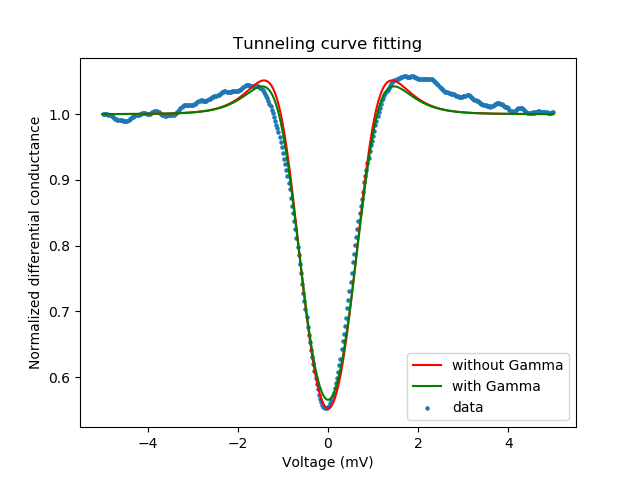

D:\anaconda\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in sqrt
D:\anaconda\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


0.9774436059817979
1.1599456118436866
-0.1892807362269739


Text(0.5,1,'Tunneling curve fitting')

In [27]:
fig, ax1 = plt.subplots()

ax1.scatter(V, dIdV, s=5, label = 'data' )
Vfine = np.linspace(-5,5,300)
ax1.plot(Vfine, list(map(lambda x: BTK_df_T_G( x, params[0], params[1], 0), Vfine)) , 'r',label = 'without Gamma')
ax1.plot(Vfine, list(map(lambda x: BTK_df_T_G( x, params_2[0], params_2[1], params_2[2]),  Vfine)), 'g', label = 'with Gamma' )
#ax.plot(Vfine, list(map(lambda x: BTK_df( x, params[0], params[1], T), Vfine)) )

print(params_2[0])
print(params_2[1])
print(params_2[2])
#plt.xlim(-10,10)

plt.xlabel('Voltage (mV)')
plt.ylabel('Normalized differential conductance')
plt.legend( loc='lower right')

plt.title('Tunneling curve fitting')


In [114]:
deltas = []


for i in range(len(Tarray)):
    Ti = Tarray[i]

    V=V_all[Tarray[i]].tolist()
    dIdVi=dIdV_all[Tarray[i]].tolist()
    dIdVi_normalized = list(map(lambda x: x/dIdVi[0],dIdVi))
    
    Deli = 0.8
    Zi = 1
    params = Deli, Zi
    
    for j in range (10):
        params, params_covariance = optimize.curve_fit( BTK_df_T , V , dIdV, params, maxfev=5000)

    deltas.append(params[0])

print(deltas)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt
D:\anaconda\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in sqrt


[0.8092839325018873, 0.8091126551121894, 0.6265721010312795, 0.5764501579373238, 0.726823012479633, 0.4260812142219628, 0.8089622145941764, 0.8088145806049958, 0.8588342813903469, 0.8084313600119434, 0.7934812740732335, 0.7308172885539072, 0.9191395678085303, 0.677706464208226]


<IPython.core.display.Javascript object>


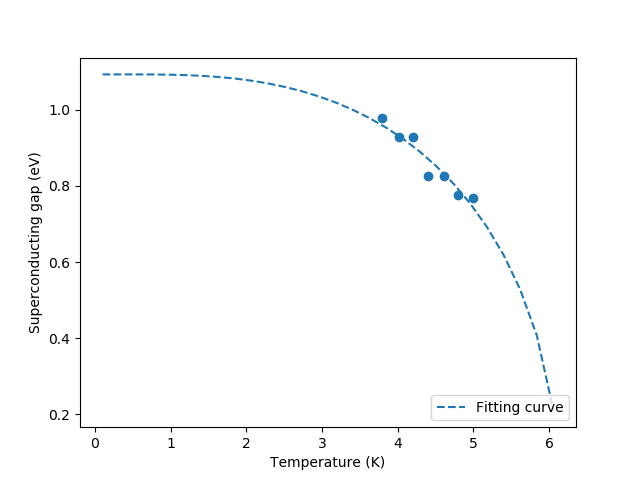

[3.79353, 4.01176, 4.20817, 4.40685, 4.61041, 4.80139, 5.002, 5.20091, 5.40942, 5.60429, 5.80265, 6.00404, 6.20504, 6.40216]


D:\anaconda\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


Text(0,0.5,'Superconducting gap (eV)')

In [132]:
fig, ax = plt.subplots()

Tsort = Tarray.copy()
Tsort.sort()
print(Tsort)


deltas = [0.9774436059817979, 0.92731827, 
          0.9273182889802449  , 0.8270676, 
          0.82706764, 0.77694234, 
          0.767342813, 0.67669173, 
          0.67669172, 0.5764411, 
          0.62656641 , 0.541054 , 
          0.4581453  , 0.42606516 ]

Zs = [1.1599456118436866, 1.15867615,
     1.09739206 , 1.115427,
     1.05111102, 1.02330716,
     0.939508145, 0.91529863,
     0.87022604, 0.87556847,
     0.84763421, 12.12534043,
     0.88554894, 0.87043889  ]


Gs = [0.1892807362269739, 0.16393906,
     0.19209697, 0.19307613,
     0.23761806, 0.22804936,
     1.97010394e+05, 10.73863538,
     7.01730883, 4.88881087,
     1.36017323, 23.87468369,
     10.12374071, 6.9482265]

delta0 = 1.09257754 
Tc0 = 6.1349846

def delta_tan(T):
    return delta0*np.tanh(1.74*np.sqrt(Tc0/T-1))

ax.scatter( Tsort[:7], deltas[:7] )
Tfine = np.linspace(0.1, 6.5, 30)

ax.plot(Tfine, list(map(lambda x: delta_tan(x), Tfine)), linestyle = 'dashed', label = 'Fitting curve')
plt.legend( loc='lower right')
plt.xlabel('Temperature (K)')
plt.ylabel('Superconducting gap (eV)')

<IPython.core.display.Javascript object>


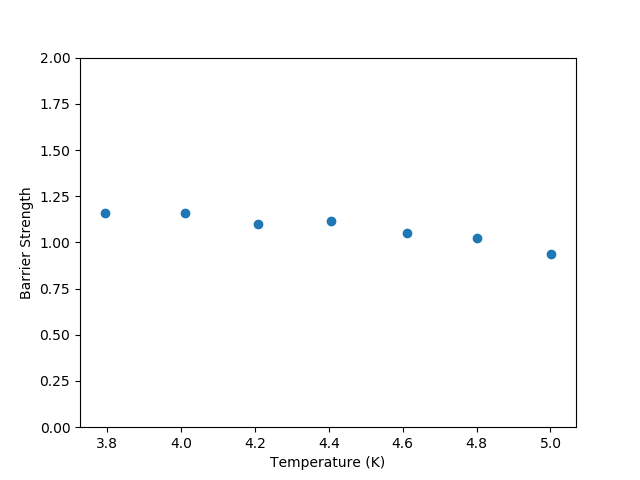

Text(0,0.5,'Barrier Strength')

In [136]:
fig, ax = plt.subplots()
ax.scatter( Tsort[:7], Zs[:7] )

plt.ylim(0,2)

plt.xlabel('Temperature (K)')
plt.ylabel('Barrier Strength')

In [126]:
delta0 = 1.01
Tc0 = 6.66

def del_fit(T, delta, Tc):
    return delta*np.tanh(1.74*np.sqrt(Tc/T-1))


params_del = delta0, Tc0

for j in range (5):
    
    params_del, params_covariance_del = optimize.curve_fit( del_fit , Tsort[:7] , deltas[:7], params_del, maxfev=5000)

    
print( 'Fitted parameters: ')
print(params_del , params_covariance_del)

Fitted parameters: 
[1.09257754 6.1349846 ] [[ 0.00100949 -0.00513966]
 [-0.00513966  0.03139511]]


In [113]:
#An additional defination here in order to plot all the fitting in the same figure.


def df_all(E, V, T):
    kbt = k * T
    return  np.exp((E-V)/kbt) / (kbt * (np.exp((E-V)/kbt) + 1)**2)


def BTK_all(E, Del0, Z, G):
    E = np.abs(E) 
    
    #Del=Del0*np.tanh(1.74*np.sqrt(Tc0/T-1))
    Del = Del0

    miu0 = 1/2 * (1 + np.sqrt(E**2 + G**2 - Del**2)/ np.sqrt(E**2 + G**2) )
    v0 = 1/2 * (1 - np.sqrt(E**2 + G**2 - Del**2)/ np.sqrt(E**2 + G**2) )
    gamma = miu0**2 + (miu0**2 - v0**2)*Z**2
    
    if E > Del:
        A = miu0**2 * v0**2 / gamma ** 2
        B = (miu0**2 - v0**2)**2 * (Z**4 + Z**2)/ gamma**2
    else:
        A = Del**2/ (E**2 + (Del**2 - E**2) * (1 + 2* Z**2)**2)
        B = 1 - A
    return (1 + A - B)



def BTK_df_all(V, Del, Z, G, T): 

    Efine = np.linspace(-2*Vmax, 2*Vmax, 2*N)
    dE = Efine[1]-Efine[0]
    
    dIdV_inte = 0
    
    for i in range(0, len(Efine)-1, 1):
        dIdV_step = BTK_all(Efine[i], Del, Z, G) * df_all( Efine[i], V, T)
        dIdV_inte = dIdV_step * dE + dIdV_inte
    return dIdV_inte * (1 + Z**2)




<IPython.core.display.Javascript object>


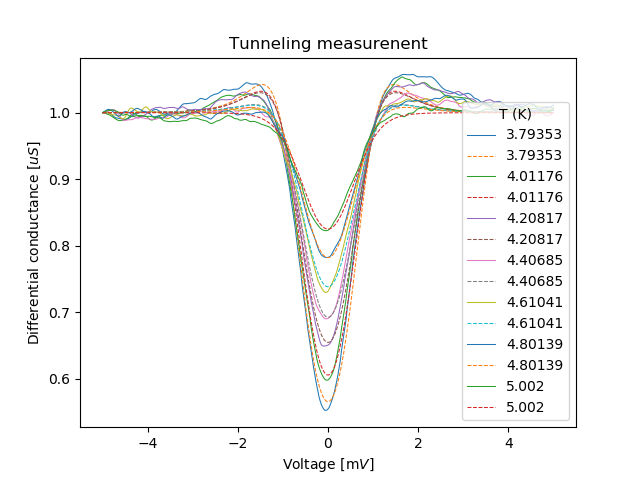

D:\anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
D:\anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


Text(0.5,1,'Tunneling measurenent')

In [124]:
fig, ax = plt.subplots()


for i in range(0,7,1):
    Vfine = np.linspace(-5,5,300)
    Vi=V_all[Tsort[i]].tolist()
    dIdVi=dIdV_all[Tsort[i]].tolist()
    dIdVi_normalized = list(map(lambda x: x/dIdVi[0],dIdVi))
    ax.plot( Vi , dIdVi_normalized , label=Tsort[i], linestyle='solid',linewidth=0.75)
    ax.plot(Vfine, list(map(lambda x: BTK_df_all( x, deltas[i], Zs[i], Gs[i], Tsort[i]), Vfine)),linestyle='dashed',linewidth=0.75, label=Tsort[i])

#default plotting method could not give a precise graph
    
plt.legend(title='T (K)', loc='lower right')
plt.ylabel('Differential conductance [$u$$S$]')
plt.xlabel('Voltage [m$V$]')
plt.title('Tunneling measurenent')